In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the image
omni_image = cv2.imread("C:/Users/govin/Documents/CV/t1152873160.272330_x4.236210_y-0.471386_a3.041985.jpeg")

In [3]:
# Define the ROI parameters
original_size =480
original_size2=640
outer_mask_radius = 220
inner_mask_radius = 65
center_x = original_size // 2
center_y = original_size2 // 2

# Create a binary mask for the ROI
mask = np.zeros_like(omni_image[:, :, 0])
rows, cols = np.indices(mask.shape)
distance = np.sqrt((rows - center_x)**2 + (cols - center_y)**2)
mask[(distance <= outer_mask_radius) & (distance >= inner_mask_radius)] = 1

# Apply the mask to extract the ROI
roi_image = cv2.bitwise_and(omni_image, omni_image, mask=mask)

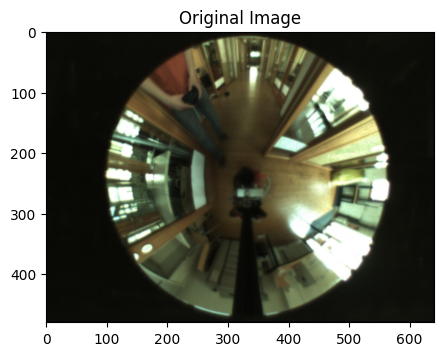

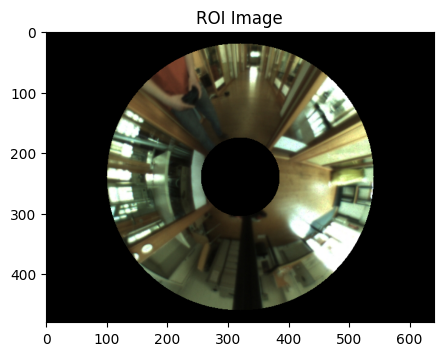

In [4]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(cv2.cvtColor(omni_image, cv2.COLOR_BGR2RGB))
ax.set_title("Original Image")
plt.show()
    
# Display the ROI image with convex hulls
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(cv2.cvtColor(roi_image, cv2.COLOR_BGR2RGB))
ax.set_title("ROI Image")
plt.show()
    

In [5]:
# Create an ORB object
orb = cv2.ORB_create()

# Detect keypoints and compute descriptors
keypoints, descriptors = orb.detectAndCompute(roi_image, None)

# Draw keypoints on the image
img_kp = cv2.drawKeypoints(roi_image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT, color=(0, 0, 255))

In [6]:
len(keypoints)

500

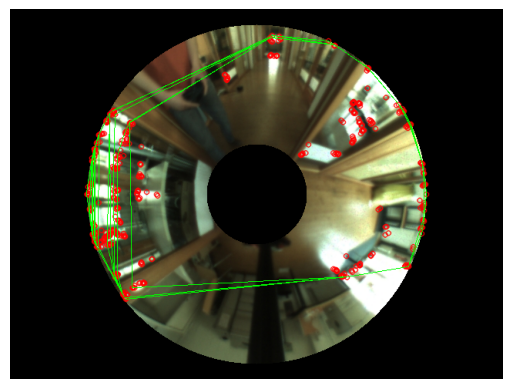

Number of Convex Hull Layers: 5


In [15]:
# Convert keypoints to points
points = np.array([kp.pt for kp in keypoints], dtype=np.float32)

# Sort points based on their x-coordinate
sorted_points = sorted(points, key=lambda x: x[0])

# Find the convex hull using Graham scan algorithm
def orientation(p, q, r):
    return (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])

def convex_hull(points):
    n = len(points)
    if n < 3:
        return []

    hull = []
    l = 0
    for i in range(1, n):
        if points[i][0] < points[l][0]:
            l = i

    p = l
    q = None
    while True:
        hull.append(points[p])
        q = (p + 1) % n
        for i in range(n):
            if orientation(points[p], points[i], points[q]) < 0:
                q = i
        p = q
        if p == l:
            break

    return hull

# Number of layers of convex hulls
num_layers = 5

# Iterate to find multiple layers of convex hulls
remaining_points = sorted_points
convex_hull_layers = []  # Store the convex hull layers
for layer in range(num_layers):
    # Find the convex hull of the remaining points
    convex_hull_points = convex_hull(remaining_points)

    # Break the loop if no more convex hulls can be found
    if len(convex_hull_points) < 3:
        break

    # Convert the convex hull points to an array
    convex_hull_points = np.array(convex_hull_points, dtype=np.int32)

    # Draw the convex hull on the image
    cv2.polylines(img_kp, [convex_hull_points], isClosed=True, color=(0, 255, 0), thickness=1)

    # Remove the points inside the convex hull from the remaining points
    remaining_points = [point for point in remaining_points if point not in convex_hull_points]
    
    # Remove 50 points from the remaining points
    remaining_points = remaining_points[30:]

    # Add the convex hull points to the convex hull layers
    convex_hull_layers.append(convex_hull_points)

# Display the image with keypoints and multiple layers of convex hulls with increased size

plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Print the number of convex hull layers found
print("Number of Convex Hull Layers:", len(convex_hull_layers))


In [16]:
print(convex_hull_layers)

len(convex_hull_layers[1])

[array([[ 99, 240],
       [100, 230],
       [106, 193],
       [109, 181],
       [115, 163],
       [124, 144],
       [129, 135],
       [133, 131],
       [134, 131],
       [340,  34],
       [413,  41],
       [465,  76],
       [509, 129],
       [511, 132],
       [520, 149],
       [535, 200],
       [539, 227],
       [540, 240],
       [537, 275],
       [534, 291],
       [517, 333],
       [515, 334],
       [437, 347],
       [150, 376],
       [146, 370],
       [112, 308],
       [109, 301],
       [107, 293],
       [106, 291]]), array([[107, 197],
       [109, 181],
       [115, 162],
       [124, 145],
       [129, 135],
       [133, 131],
       [337,  37],
       [349,  35],
       [421,  46],
       [464,  76],
       [504, 123],
       [509, 131],
       [519, 150],
       [535, 200],
       [536, 208],
       [536, 212],
       [537, 226],
       [537, 253],
       [536, 273],
       [517, 333],
       [515, 334],
       [437, 347],
       [149, 374],
       [1

28

In [17]:
len(convex_hull_layers[4])

21

In [19]:

def hull_census_transform(descriptors, convex_hull):
    binary_code = []
    num_points = len(convex_hull)

    for i in range(num_points):
        current_point = convex_hull[i]
        next_point = convex_hull[(i + 1) % num_points]  # Wrap around to the first point for the last one

        current_idx = current_point[0] % len(descriptors)
        next_idx = next_point[0] % len(descriptors)

        current_desc = descriptors[current_idx]
        next_desc = descriptors[next_idx]

        if np.linalg.norm(current_desc) > np.linalg.norm(next_desc):
            binary_code.append(1)
        else:
            binary_code.append(0)

    return binary_code


# Initialize an empty list to store the binary codes
binary_codes = []

# Iterate over the convex hull layers
for layer in convex_hull_layers:
    # Compute the binary code for the layer using the Hull Census Transform
    layer_binary_code = hull_census_transform(descriptors, layer)

    # Append the binary code to the list of binary codes
    binary_codes.append(layer_binary_code)


# Display the binary codes
for i, binary_code in enumerate(binary_codes):
    print("Binary Code for Layer", i + 1, ":", binary_code)


Binary Code for Layer 1 : [0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1]
Binary Code for Layer 2 : [1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0]
Binary Code for Layer 3 : [0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1]
Binary Code for Layer 4 : [0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0]
Binary Code for Layer 5 : [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1]


In [21]:
len(binary_codes[4])

21

In [22]:
# Compute the total feature points in each convex hull
feature_points = [len(layer) for layer in convex_hull_layers]
print("Features of Convex Hulls:", feature_points)


Features of Convex Hulls: [29, 28, 23, 23, 21]


In [24]:
def calculate_cost(descriptors, convex_hull):
    cost = []

    num_points = len(convex_hull)

    for i in range(num_points):
        current_point = convex_hull[i]
        next_point = convex_hull[(i + 1) % num_points]  # Wrap around to the first point for the last one

        current_idx = current_point[0] % len(descriptors)
        next_idx = next_point[0] % len(descriptors)

        current_desc = descriptors[current_idx]
        next_desc = descriptors[next_idx]

        distance = np.linalg.norm(current_desc - next_desc)
        cost.append(distance)

    return cost


# Compute the cost of feature vectors for each convex hull layer
feature_costs = [calculate_cost(descriptors, layer) for layer in convex_hull_layers]
print("Cost of Feature Vectors:", feature_costs)


Cost of Feature Vectors: [[918.2270960933357, 613.003262634058, 914.605379385011, 813.3928939940403, 838.2797862289177, 832.3190494035325, 884.3636130008969, 904.6728690526759, 766.0868097023993, 864.7288592385477, 961.0031217431086, 741.8598250343524, 905.3170715279813, 915.6751607420614, 858.4363692202236, 792.9489264763525, 761.5714017739899, 887.9245463438884, 925.679210093864, 792.9836063879253, 755.9411352744339, 798.6344595620702, 825.3096388628937, 821.7134537051222, 896.9247460071552, 722.3918604192603, 915.2786460963678, 797.1963371717158, 824.4671006171199], [725.2082459542224, 813.3928939940403, 838.2797862289177, 832.3190494035325, 884.3636130008969, 755.0735063555071, 821.3470642791633, 852.5614347365239, 879.4901932369684, 873.6349351989079, 859.5556991841773, 799.7955988876158, 849.0771460827337, 942.3332743780196, 0.0, 893.264238621473, 0.0, 686.8602477942657, 797.6916697571813, 755.9411352744339, 798.6344595620702, 858.4054985844394, 883.6769771811416, 748.76565092156

In [25]:
def binary_to_decimal(binary_code):
    decimal_value = 0
    binary_code = binary_code[::-1]  # Reverse the binary code

    for i, bit in enumerate(binary_code):
        decimal_value += bit * (2**i)

    return decimal_value


# Compute the decimal value for each layer's binary code
decimal_values = [binary_to_decimal(binary_code) for binary_code in binary_codes]
print("Score Evaluation (Decimal Values):", decimal_values)


Score Evaluation (Decimal Values): [240200291, 210981488, 603727, 2414908, 158877]


In [26]:
# Compute the color histogram index for the image
r_channel = roi_image[:, :, 0]
g_channel = roi_image[:, :, 1]
b_channel = roi_image[:, :, 2]
wg_channel = 0.299 * r_channel + 0.587 * g_channel + 0.114 * b_channel

# Compute the histograms for each channel
hist_r = np.sum(r_channel)
hist_g = np.sum(g_channel)
hist_b = np.sum(b_channel)
hist_wg = np.sum(wg_channel)

# Normalize the histograms
WH = r_channel.size
hist_r /= WH
hist_g /= WH
hist_b /= WH
hist_wg /= WH

# Color histogram index
color_histogram_index = [hist_r, hist_g, hist_b, hist_wg]
print("Color Histogram Index:", color_histogram_index)


Color Histogram Index: [34.72970703125, 46.43587890625, 45.518932291666665, 42.8312016015625]


In [27]:
def compute_center(convex_hull):
    num_points = len(convex_hull)
    centroid = np.mean(convex_hull, axis=0)
    return centroid

def average_distance_center(points, centroid):
    num_points = len(points)
    total_distance = np.sum(np.linalg.norm(points - centroid, axis=1))
    average_distance = total_distance / num_points
    return average_distance


# Compute the average distance of the center for each convex hull layer
average_distances_center = []
for layer in convex_hull_layers:
    centroid = compute_center(layer)
    avg_distance = average_distance_center(layer, centroid)
    average_distances_center.append(avg_distance)

print("Average Distance of Center:", average_distances_center)


Average Distance of Center: [213.4840989690442, 212.29140370392253, 203.83263251236218, 204.1319706655713, 193.38688864254752]


In [28]:
def average_distance_feature(points):
    num_points = len(points)
    distances = np.linalg.norm(np.diff(points, axis=0), axis=1)
    average_distance = np.mean(distances)
    return average_distance


# Compute the average distance of the feature for each convex hull layer
average_distances_feature = []
for layer in convex_hull_layers:
    avg_distance = average_distance_feature(layer)
    average_distances_feature.append(avg_distance)

print("Average Distance of Feature:", average_distances_feature)


Average Distance of Feature: [43.86759277936869, 43.64772717470397, 54.55807086987792, 56.737601300559874, 55.791404843051964]
